# Проект для «X5 Group» по определению возраста покупателей

**Цель проекта** — помочь продуктовой компании «X5 Group» внедрить систему компьютерного зрения для обработки фотографий покупателей, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- Контролировать добросовестность кассиров при продаже алкоголя

**План работы**

Данные будут получены из директории `/datasets/faces/`. 

О качестве данных ничего не известно. Поэтому перед построением модели, понадобится обзор данных.

Мы проверим данные на пропуски, дубликаты и по возможности избавимся от них. 

Затем, мы проведем исследовательский анализ данных - опишем полученные выводы по каждому столбцу.

Далее мы создадим модель и обучим ее с помощью нейронной сети.

После мы оценим результаты модели и сделаем выводы.

## Загрузка данных

In [1]:
# Подключаем нужные библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image # Просмотр изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Напишем функцию для считывания данных из csv файла и записывания в датафрейм
def df_read_csv(pth1, pth2):
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Что-то пошло не так')

In [3]:
# Создадим функцию для считывания изображений
def load_train(labels):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
         # папка, в которой хранится датасет
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        # к какому размеру приводить изображения
        target_size=(224, 224),
        # размер батча
        batch_size=16,
        # в каком виде выдавать метки классов
        class_mode='raw',
        # указываем, что это загрузчик для тренировочной выборки
        subset='training',
        # фиксируем генератор случайных чисел (от англ. random seed)
        seed=12345)
    return train_gen_flow

In [4]:
# Создадим функцию, для отображения нужной информации о датафрейме
def df_info(df):
    display(df.head(10))
    df.info()
    display(df.describe())

In [5]:
# Считываем данные из csv файла и записываем их в переменную df
df = df_read_csv('/datasets/faces/labels.csv', 'https://code.s3.yandex.net/datasets/faces/labels.csv')

In [6]:
# Отобразим информацию о df
df_info(df)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
# Считываем данные для изображений
train_datagen_flow = load_train(df)

Found 5694 validated image filenames.


После загрузки необходимых файлов, имеем 1 датафрейм и 2 уникальных столбца с данными.

В датафрейме `df` мы сохранили набор данных с номерами фотографий и возрастом людей, на этих фотографиях.

**Описание данных:**
1. file_name — номер фотографии
2. real_age — возраст человека на фотографии

## Предобработка данных

### Выставление корректных типов данных

**Преобразуем тип данных int 64 в int 32 для экономии памяти в столбцах:**
- `real_age`

In [8]:
df['real_age'] = df['real_age'].astype('int32')

### Удаление пропусков

**Определим кол-во пропусков в каждом столбце**

In [9]:
df.isna().sum()

file_name    0
real_age     0
dtype: int64

Пропуски не обнаружены

### Обработка дубликатов

**Найдем явные дубликаты**

In [10]:
# Найдем явные дубликаты
print(df.duplicated().sum())

0


Явные дубликаты не найдены.

На этапе предобработки данных, нам удалось:
1. Проверить данные на наличие пропусков
2. Выставить корректные типы данных для экономии памяти
3. Проверить данные на наличие дубликатов

## Исследовательский анализ данных

In [11]:
# Создадим функцию для отображения количественных признаков
def quant_feat(df, col, title, xlabel, ylabel):
    # Отобразим данные в столбце col
    display(df[col].describe())
    
    # Отобразим гистограмму, построенную для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.histplot(df[col], bins=100).set(xlabel=xlabel, ylabel=ylabel);
    
    # Отобразим ящик с усами, построенный для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.boxplot(df[col]).set(ylabel=xlabel);

In [12]:
# Создадим функцию для печати изображений
def print_image(df):
    features, target = next(df)

# Напечатаем на экране 15 фотографий и посмотрим, как устроен датасет.
    n, m = 5, 3
    fig = plt.figure(figsize=(10,10))
    for i in range(n * m):
        fig.add_subplot(m, n, i+1)
        # отобразим возраст в названии каждого фото
        plt.title(target[i]) 
        plt.imshow(features[i])
        # для компактности удалим оси и прижмём изображения друг к другу
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()


### Изучим и опишем данные из таблицы df

**Изучим столбец `real_age`**

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


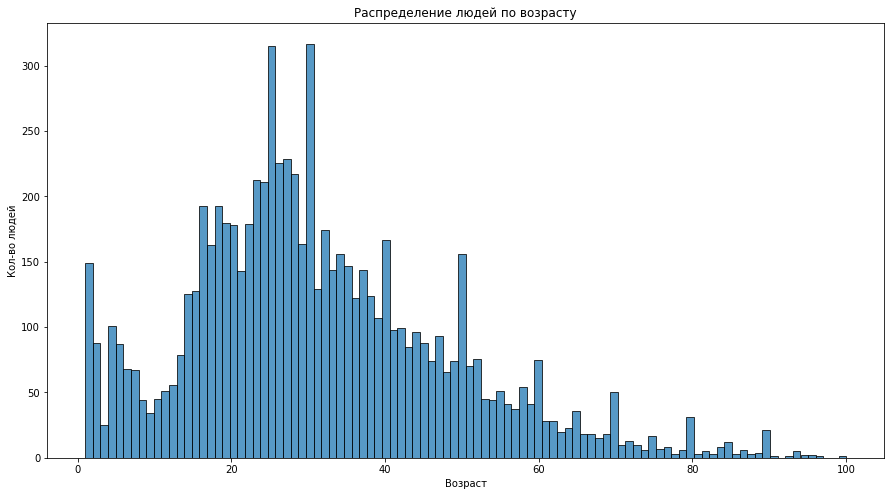

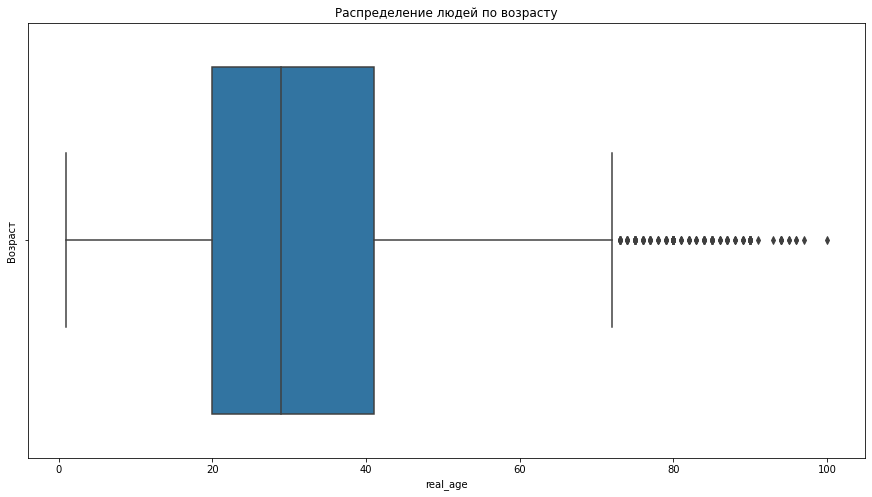

In [13]:
# Отобразим данные в столбце real_age
quant_feat(df, 'real_age', 'Распределение людей по возрасту', 'Возраст', 'Кол-во людей')

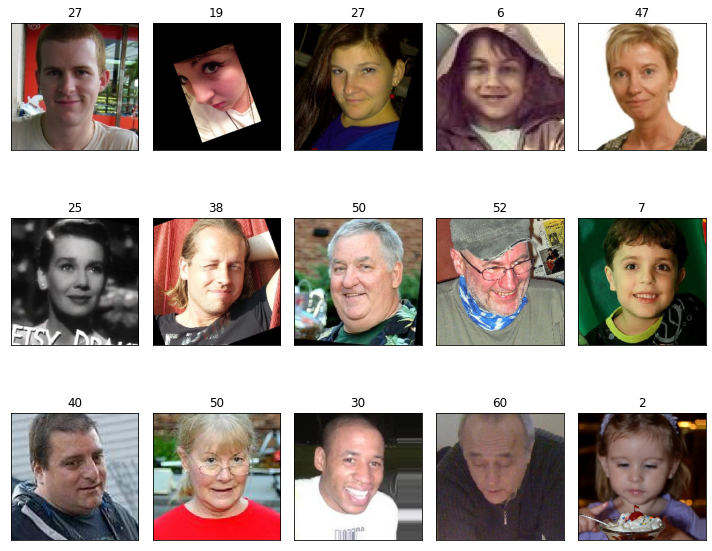

In [14]:
print_image(train_datagen_flow)

На этапе исследовательского анализа данных, нам удалось:
1. Изучили и описали данные из таблицы df

По полученым данным, можно сказать:
1. Суммарное кол-во изображений в датасете - 7591. Этого должно быть достаточно для обучения нейросети, ранее предобученной на большой выборке ImageNet.
2. Средний возраст людей на фото - 31 год
3. В 99% случаев возраст людей на фото не превышает 73 лет
4. Половина людей в датасете имеет возраст от 20 до 41 года
5. На графике виден всплеск ближе к нулю
6. Начиная с 40 лет, заметны всплески на каждом десятилетие - 50, 60, 70, 80 лет. Это может свидетельствовать о возможном округлении целевых значений возрастов при их разметке. Это будет создавать помехи для предсказания точного возраста.

По полученным изображениям, можно сказать:
1. Часть фотографий содержат артефакты в виде черного фона, оставшегося после поворота и обрезки фотографий.

## Обучение модели

### Обучим модель

```python

# Подключаем нужные библиотеки
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error

# Создадим функцию для загрузки тренировочной выборки
def load_train(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.0
    )

    df = pd.read_csv(path + 'labels.csv', engine='python')
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

# Создадим  функцию для загрузки тестовой выборки
def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.0
    )

    df = pd.read_csv(path + 'labels.csv', engine='python')
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

# Создадим функцию для генерации модели ResNet50
def create_model(input_shape): 
    backbone = ResNet50(
        input_shape=input_shape, 
        include_top=False, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['mae'])
    return model

# Создадим функцию для обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    return model

```

### Выведем результат обучения модели

```

2025-05-04 14:02:59.575191: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-05-04 14:02:59.652528: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-05-04 14:03:07.902629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-05-04 14:03:08.562616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-05-04 14:03:08.562692: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-05-04 14:03:08.562728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-04 14:03:08.669507: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-05-04 14:03:08.684263: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-05-04 14:03:08.813483: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-05-04 14:03:08.832535: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-05-04 14:03:08.832648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-05-04 14:03:08.837487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2025-05-04 14:03:10.845822: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-05-04 14:03:10.901148: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2025-05-04 14:03:10.903506: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5fc5180 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-05-04 14:03:10.903548: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-05-04 14:03:11.117862: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5f63760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-04 14:03:11.117908: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-05-04 14:03:11.120613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-05-04 14:03:11.120717: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-05-04 14:03:11.120748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-04 14:03:11.120795: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-05-04 14:03:11.120833: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-05-04 14:03:11.120879: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-05-04 14:03:11.120917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-05-04 14:03:11.120951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-05-04 14:03:11.125719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-05-04 14:03:11.128080: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-05-04 14:03:13.292434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-05-04 14:03:13.292490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-05-04 14:03:13.292505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-05-04 14:03:13.297369: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-05-04 14:03:13.297464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/15
2025-05-04 14:03:33.518035: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-04 14:03:35.068132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 85s - loss: 203.0242 - mae: 10.4291 - val_loss: 440.0128 - val_mae: 15.8384
Epoch 2/15
356/356 - 46s - loss: 70.2378 - mae: 6.4067 - val_loss: 145.5845 - val_mae: 8.9381
Epoch 3/15
356/356 - 46s - loss: 37.4511 - mae: 4.6955 - val_loss: 90.9243 - val_mae: 7.0709
Epoch 4/15
356/356 - 46s - loss: 24.4358 - mae: 3.8432 - val_loss: 95.4586 - val_mae: 7.3541
Epoch 5/15
356/356 - 46s - loss: 18.9899 - mae: 3.3549 - val_loss: 80.6055 - val_mae: 6.6117
Epoch 6/15
356/356 - 46s - loss: 15.9641 - mae: 3.0550 - val_loss: 77.8080 - val_mae: 6.8406
Epoch 7/15
356/356 - 46s - loss: 12.8296 - mae: 2.7223 - val_loss: 71.3872 - val_mae: 6.3022
Epoch 8/15
356/356 - 46s - loss: 10.7635 - mae: 2.5021 - val_loss: 66.4035 - val_mae: 6.1174
Epoch 9/15
356/356 - 46s - loss: 10.1427 - mae: 2.3898 - val_loss: 71.8678 - val_mae: 6.4017
Epoch 10/15
356/356 - 46s - loss: 8.9594 - mae: 2.2571 - val_loss: 66.7933 - val_mae: 6.2100
Epoch 11/15
356/356 - 45s - loss: 8.3326 - mae: 2.1692 - val_loss: 66.3676 - val_mae: 6.2396
Epoch 12/15
356/356 - 45s - loss: 8.5066 - mae: 2.2253 - val_loss: 66.1562 - val_mae: 6.0753
Epoch 13/15
356/356 - 45s - loss: 9.2276 - mae: 2.3059 - val_loss: 72.0307 - val_mae: 6.2086
Epoch 14/15
356/356 - 45s - loss: 9.1979 - mae: 2.3211 - val_loss: 66.3008 - val_mae: 6.0213
Epoch 15/15
356/356 - 46s - loss: 8.7105 - mae: 2.2170 - val_loss: 67.0712 - val_mae: 6.2529
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 67.0712 - mae: 6.2529





```

Метрика MAE на тестовой выборке - 6.25

### Обучим модель с использованием горизонтальной аугментации

```python

# Подключаем нужные библиотеки
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error

# Создадим функцию для загрузки тренировочной выборки, добавим горизонтальную аугментацию
def load_train(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.0,
        horizontal_flip=True
    )

    df = pd.read_csv(path + 'labels.csv', engine='python')
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

# Создадим  функцию для загрузки тестовой выборки
def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.0
    )

    df = pd.read_csv(path + 'labels.csv', engine='python')
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

# Создадим функцию для генерации модели ResNet50
def create_model(input_shape): 
    backbone = ResNet50(
        input_shape=input_shape, 
        include_top=False, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['mae'])
    return model

# Создадим функцию для обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    return model

```

### Выведем результат обучения модели с использованием горизонтальной аугментации

```

2025-05-05 07:13:16.313970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-05-05 07:13:16.315986: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-05-05 07:13:17.424011: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-05-05 07:13:17.937584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-05-05 07:13:17.937654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-05-05 07:13:17.937694: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-05 07:13:17.939831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-05-05 07:13:17.940276: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-05-05 07:13:17.942643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-05-05 07:13:17.943948: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-05-05 07:13:17.944010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-05-05 07:13:17.947900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2025-05-05 07:13:19.373415: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-05-05 07:13:19.381779: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2025-05-05 07:13:19.382348: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4751280 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-05-05 07:13:19.382378: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-05-05 07:13:19.515036: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4442720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-05 07:13:19.515082: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-05-05 07:13:19.517156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-05-05 07:13:19.517217: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-05-05 07:13:19.517231: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-05 07:13:19.517259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-05-05 07:13:19.517275: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-05-05 07:13:19.517289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-05-05 07:13:19.517302: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-05-05 07:13:19.517312: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-05-05 07:13:19.521152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-05-05 07:13:19.521218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-05-05 07:13:19.900597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-05-05 07:13:19.900656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-05-05 07:13:19.900666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-05-05 07:13:19.904617: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-05-05 07:13:19.904676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/15
2025-05-05 07:13:34.941437: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-05 07:13:35.308279: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 84s - loss: 193.9243 - mae: 10.2012 - val_loss: 587.2963 - val_mae: 19.2102
Epoch 2/15
356/356 - 47s - loss: 84.5539 - mae: 6.9697 - val_loss: 174.6696 - val_mae: 9.8281
Epoch 3/15
356/356 - 47s - loss: 55.1528 - mae: 5.6963 - val_loss: 115.7416 - val_mae: 8.3959
Epoch 4/15
356/356 - 47s - loss: 44.4283 - mae: 5.1123 - val_loss: 90.6404 - val_mae: 6.9748
Epoch 5/15
356/356 - 47s - loss: 31.8243 - mae: 4.3508 - val_loss: 73.9037 - val_mae: 6.4467
Epoch 6/15
356/356 - 47s - loss: 25.3368 - mae: 3.8411 - val_loss: 85.6984 - val_mae: 7.1574
Epoch 7/15
356/356 - 47s - loss: 19.7123 - mae: 3.3918 - val_loss: 66.5391 - val_mae: 6.1119
Epoch 8/15
356/356 - 47s - loss: 15.4339 - mae: 2.9971 - val_loss: 67.4425 - val_mae: 6.0546
Epoch 9/15
356/356 - 47s - loss: 14.6961 - mae: 2.9117 - val_loss: 83.5011 - val_mae: 7.1162
Epoch 10/15
356/356 - 47s - loss: 13.2669 - mae: 2.7570 - val_loss: 63.7275 - val_mae: 5.8480
Epoch 11/15
356/356 - 47s - loss: 12.3024 - mae: 2.6298 - val_loss: 64.9781 - val_mae: 6.0522
Epoch 12/15
356/356 - 47s - loss: 11.3785 - mae: 2.5661 - val_loss: 62.8776 - val_mae: 5.8351
Epoch 13/15
356/356 - 47s - loss: 11.0410 - mae: 2.5116 - val_loss: 64.7715 - val_mae: 5.8491
Epoch 14/15
356/356 - 47s - loss: 11.0100 - mae: 2.5071 - val_loss: 67.2294 - val_mae: 6.0540
Epoch 15/15
356/356 - 47s - loss: 10.2090 - mae: 2.4254 - val_loss: 67.0503 - val_mae: 6.0781
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 67.0503 - mae: 6.0781





```

Метрика MAE на тестовой выборке - 6.07

На этапе анализа моделей, нам удалось:
1. Построить и обучить свёрточную нейронную сеть ResNet50 глубиной в 50 слоев на датасете с фотографиями людей.
2. Протестировать две ее вариации - с горизонтальной аугментацией и без
3. Наилучший результат показала модель с горизонтальной аугментацией - метрика МАЕ на тестовой выборке равна 6.07
2. Метрика MAE на тестовой выборке - 6.07, что ниже требуемого значения 8

## Анализ обученной модели

**По полученным результатам можно сделать следующие выводы:**
1. Поскольку MAE измеряется в абсолютных величинах, то полученый результат означает, что созданная модель ошибается в предсказании возраста человека по его фотографиии не более чем 6.25 лет
2. Причина такой весомой ошибки - датасет, использовавшийся для обучения. В нем большая часть фотографий принадлежит людям в возрасте от 20 до 40 лет. Не хвает фотографий возрастных групп от 0 до 20 и от 40 до 100 лет. Если дополнить датасет фотографий из недостающих возрастных категорий, то качество модели улучшится.
3. Также на качестве обучения сказалось возможное округление до 10 целевых значений после 40 лет. Это возможно исправить только более качественной разметкой целевых признаков.

**С точки зрения поставленных бизнес задач, можно порекомендовать следующее:**
1. Модель можно использовать для анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы.
2. Модель не стоит использовать для контролирования добросовестности кассиров при продаже алкоголя - так как на этом этапе обучения она недостаточно точна.